# Least squares conformal maps

[original publication](https://inria.hal.science/inria-00100754)

The goal of this method is to automatically unfold a mesh for texture mapping. An unfolding consists in assigning 2D $(u,v)$ coordinates to each vertex of the mesh, while trying to preserve the triangle shape to avoid texture deformation. A conformal map preserves angles. This means that triangles qill have the same shape, but since lengths are not necessarily preserved, triangles may be uniformly scaled.

In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from pygel3d import hmesh
from pygel3d import jupyter_display as jd
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

jd.set_export_mode(True)

In [2]:
def plot_vectors(vectors, origins = None, **kwargs):
    head_width = 0.05
    if 'head_width' in kwargs:
        head_width = kwargs['head_width']
        del kwargs['head_width']
            
    drawto = plt.gca()
    if 'ax' in kwargs:
        drawto = kwargs['ax']
        del kwargs['ax']
        
    arrows = []
    if origins is None:
        for v in vectors:
            arrows.append(patches.FancyArrow(
            0,0,v[0],v[1],
            head_width = head_width, length_includes_head = True,
            **kwargs
            ))
    else:
        for v,o in zip(vectors, origins):
            arrows.append(patches.FancyArrow(
            o[0], o[1],v[0],v[1],
            head_width = head_width, length_includes_head = True,
            **kwargs
            ))
        
    collection = matplotlib.collections.PatchCollection(arrows, match_original = True)
    drawto.add_collection(collection)
    
def plot_vector(vector, origin = None, **kwargs):
    if origin is None:
        plot_vectors([vector], **kwargs)
    else:
        plot_vectors([vector], [origin], **kwargs)

## Conformal parametrization

A parametrization assigns $(u,v)$ coordinates to each vertex of the input mesh. Triangles in 3D are then mapped linearly to 2D triangles. Given a point on a triangle, its $(u,v)$ coordinates are linearly interpolated from the coordinates of the triangle vertices. For the mapping to be conformal, the *gradient* of the $u$ coordinate in the triangle has to be orthogonal to the gradient of the $v$ coordinate, and both should have the same norm. In other words, the gradient of $v$ should be a $\frac{\pi}{2}$ rotation of the gradient of $u$. We therefore need to compute these gradients. 

Givent a triangle $(\mathbf{p_0}, \mathbf{p_1}, \mathbf{p_2})$ and a point $\mathbf{p}$ in the triangle, the barycentric coordinate of $\mathbf{p}$ with respect to the vertex $\mathbf{p_0}$ is the ratio between the signed areas of the triangles $(\mathbf{p}, \mathbf{p_1}, \mathbf{p_2})$ and $(\mathbf{p_0}, \mathbf{p_1}, \mathbf{p_2})$. This ratio can be computed with determinants and cross products.

In [3]:
def interp(pts, i, x, y):
    p0 = pts[i]
    p1 = pts[(i+1)%3]
    p2 = pts[(i+2)%3]
    #twice signed area of triangle (p0, p1, p2)
    area = np.cross(p2 - p0, p1 - p0)[2]
    #twice signed area of triangle (p, p1, p2)
    det = (x - p1[0])*(p2[1]-p1[1]) - (y - p1[1])*(p2[0] - p1[0])
    #ratio
    return det / area

In [4]:
p = np.array([
    [0.1, 0.1, 0],
    [0.9, 0.3, 0],
    [0.4, 0.8, 0]
])

for i in range(3):
    for j in range(3):
        print(interp(p, i, *p[j, :2]))
    print("=====")

test_p = 0.2 * p[0] + 0.5 * p[1] + 0.3 * p[2]
print(interp(p, 0, *test_p[:2]))
print(interp(p, 1, *test_p[:2]))
print(interp(p, 2, *test_p[:2]))

1.0
-0.0
-0.0
=====
-0.0
1.0
-0.0
=====
-0.0
-0.0
1.0
=====
0.19999999999999996
0.5000000000000002
0.29999999999999993


In [5]:
x,y = np.meshgrid(np.arange(0,1,0.01), np.arange(0,1,0.01))

a0 = interp(p, 0, x, y)
a1 = interp(p, 1, x, y)
a2 = interp(p, 2, x, y)

Let us now visualize the interpolated function. The interpolation being linear, the gradient of the interpolation is actually constant with evenly spaced parallel contour lines.

In [6]:
def plot_interpolation(v0, v1, v2):
    f = a0*v0 + a1*v1 + a2*v2
    fmin = np.min(f)
    fmax = np.max(f)
    plt.pcolormesh(x, y, f)
    plt.contour(x, y, f, np.linspace(fmin, fmax, 20) , linewidths = 0.5, colors='black', linestyles = 'solid')
    plt.triplot(p[:,0], p[:,1], linewidth = 3, color = 'black')
    plt.scatter(p[:,0], p[:,1], c=[v0, v1, v2], linewidth=1, edgecolor='black', vmin = fmin, vmax = fmax)


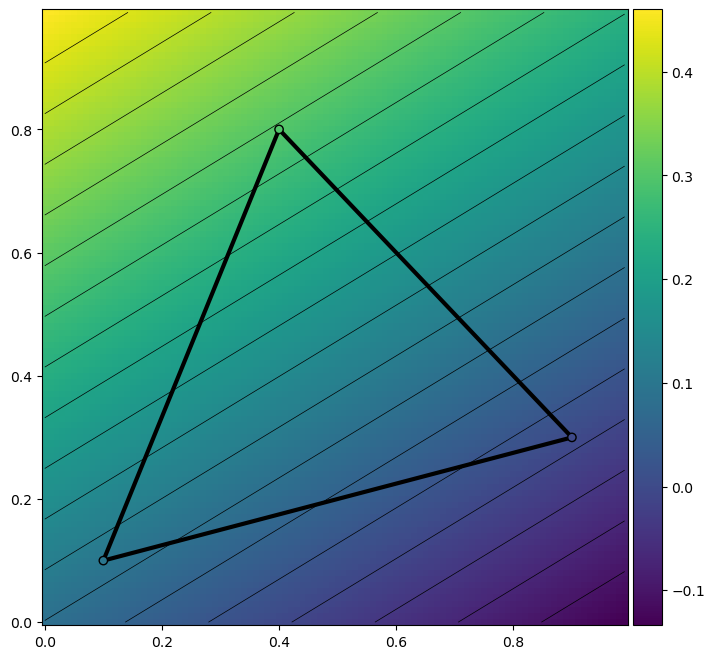

In [7]:
def animate_interpolation(v0 = 0.1, v1 = 0., v2 = 0.3):
    fig,ax = plt.subplots(figsize=(8,8))
    plot_interpolation(v0, v1, v2)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.show()

#_ = widgets.interact(animate_interpolation, v0 = (0,1, 0.01), v1 = (0,1,0.01), v2 = (0,1,0.01))
animate_interpolation()

The gradient can be computed by differenciating the barycentric coordinates. Formally the interpolated function is given by :

$$ v(\mathbf{p}) = a_0(\mathbf{p}) u_0 + a_1(\mathbf{p}) u_1 + a_2(\mathbf{p}) u_2$$

with a_i(x,y) being the barycentric coordinates of the point $\mathbf{p}$ in the triangle and $v_i$ beging the interpolated values at the triangle vertices. Differenciating, we get 

$$ \mathrm{d}v(\mathbf{p}) = \mathrm{d}a_0(\mathbf{p}) u_0 + \mathrm{d}a_1(\mathbf{p}) u_1 + \mathrm{d}a_2(\mathbf{p}) u_2$$

As mentionned, barycentric coordinates are signed triangle area ratios, which can be computed as

$$ 
    a_0(\mathbf{p}) = 
    \frac{
        (\mathbf{p} - \mathbf{p_1})\times(\mathbf{p2} - \mathbf{p1}).\mathbf{n}
    }{
        (\mathbf{p_0} - \mathbf{p_1})\times(\mathbf{p2} - \mathbf{p1}).\mathbf{n}
    } 
$$
    
with $\mathbf{n}$ being the normal of the triangle. With 
$\mathbf{n} = (\mathbf{p_0} - \mathbf{p_1})\times(\mathbf{p2} - \mathbf{p1})$, differenciating, we get

$$ 
    \mathrm{d}a_0(\mathbf{p}) = 
    \mathrm{d}\frac{
        (\mathbf{p} - \mathbf{p_1})\times(\mathbf{p2} - \mathbf{p1}).\mathbf{n}
    }{
        \mathbf{n}^2
    }
    =
    \frac{
        \mathrm{d}\mathbf{p}\times(\mathbf{p2} - \mathbf{p1}).\mathbf{n}
    }{
        (\mathbf{n}^2
    }
$$

reordering the mixed products, we get 

$$ 
    \mathrm{d}a_0(\mathbf{p}) = 
    \frac{
        (\mathbf{p2} - \mathbf{p1})\times\mathbf{n}.\mathrm{d}\mathbf{p}
    }{
        \mathbf{n}^2
    }
$$

which yields the gradient

$$
    \nabla{a_0}(\mathbf{p}) = 
    \frac{
        (\mathbf{p2} - \mathbf{p1})\times\mathbf{n}
    }{
        \mathbf{n}^2
    }
$$

To check this result, we can visualize this gradient and ensure that it is orthogonal to the contour lines, goes from small values to big values and vanishes when the function is constant.

In [8]:
def interp_gradient(v0, v1, v2):
    n = np.cross(p[2] - p[0], p[1] - p[0])
    da0 = np.cross(p[2] - p[1], n)
    da1 = np.cross(p[0] - p[2], n)
    da2 = np.cross(p[1] - p[0], n)
    return (v0 * da0 + v1 * da1 + v2 * da2) / n.dot(n)

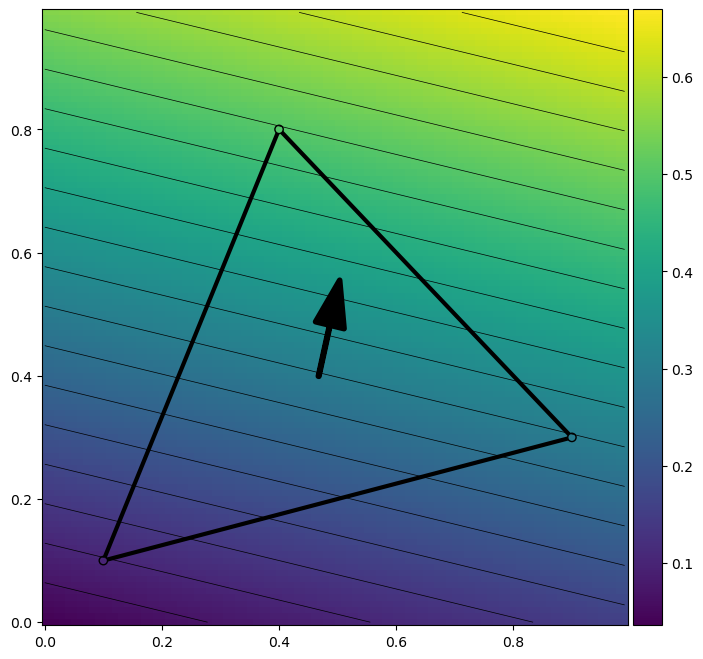

In [9]:


def animate_gradient(v0 = 0.1, v1 = 0.3, v2 = 0.5):
    fig,ax = plt.subplots(figsize=(8,8))

    plot_interpolation(v0, v1, v2)
    g = interp_gradient(v0, v1, v2)
    mid = (p[0] + p[1] + p[2]) / 3
    plot_vector(0.3 * g, mid, color = 'black', linewidth = 4)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)

    plt.show()

#_ = widgets.interact(animate_gradient, v0 = (0,1, 0.01), v1 = (0,1,0.01), v2 = (0,1,0.01))
animate_gradient()

Now whats interesting is that this gradient depends linearly on the interpolated values at the vertices. Conformal constraints can therefore translate into linear constraints on the $(u,v)$ coordinates of the vertices. For each triangle in the input mesh, this yields two linear equations. Expressing gradients in a local $(x,y)$ frame of the triangle, we get

$$
    \nabla{u}(x,y) = \nabla{a_0}(x,y)u_0 + \nabla{a_1}(x,y)u_1 + \nabla{a_2}(x,y)u_2
$$
$$
    \nabla{v}(x,y) = \nabla{a_0}(x,y)v_0 + \nabla{a_1}(x,y)v_1 + \nabla{a_2}(x,y)v_2
$$

In 2D, $\nabla{v}(x,y)$ is a $\frac{\pi}{2}$ rotation of $\nabla{u}(x,y)$ if

$$
    \nabla{v}(x,y)_x = - \nabla{u}(x,y)_y \quad \mbox{and} \quad \nabla{v}(x,y)_y = \nabla{u}(x,y)_x
$$

In this local frame, the coordinates of the gradients can be simply expressed in terms of the coordinates of the triangle vertices

$$
    \nabla{a_0}(x,y) =
    \frac{
        (\mathbf{p2} - \mathbf{p1})\times\mathbf{n}
    }{
        \mathbf{n}^2
    }
    =
    \frac{
        \begin{pmatrix}x_2 - x_1 \\ y_2 - y_1 \\ 0\end{pmatrix}\times\begin{pmatrix}0 \\ 0 \\ n_z\end{pmatrix}
    }{
        n_z^2
    }
$$

With the convention we used, $n_z = -2T$ with $T$ being the triangle area. Expressing everything in terms of the triangle area $T$, we get

$$
    \nabla{a_0}(x,y) = \frac{1}{2T} \begin{pmatrix}y_1 - y_2 \\ x_2 - x_1 \\ 0\end{pmatrix}
$$

and therefore

$$
    \nabla{a_0}(x,y)_x = \frac{1}{2T}(y_1 - y_2) \quad \mbox{and} \quad \nabla{a_0}(x,y)_y = \frac{1}{2T}(x_2 - x_1)
$$

This finally yields the two equations

$$
    \frac{1}{2T}\left((y_1 - y_2)v_0 + (y_2 - y_0)v_1 + (y_0 - y_1)v_2\right) = \frac{-1}{2T}\left((x_2 - x_1)u_0 + (x_0 - x_2)u_1 + (x_1 - x_0)u_2\right)
$$
$$
    \frac{1}{2T}\left((x_2 - x_1)v_0 + (x_0 - x_2)v_1 + (x_1 - x_0)v_2\right) = \frac{1}{2T}\left((y_1 - y_2)u_0 + (y_2 - y_0)u_1 + (y_0 - y_1)u_2\right)
$$

## Building a least squares problem

Two equations per faces is too many equations with respect to the number of variables. This system of equations is therefore solved in the least squares manner. In addition, the expected result is a parameterization preserving the angles of the input triangles. However, scaling or rotating the parameterization does not change the angles of the parameterization. To ensure the unicity of the results, two vertices have to be pinned at specific coordinates. More vertices can be b=pinned, thus removing degrees of freedom in the problem. Pinned vertices form the right hand side of the resulting linear system.

In [10]:
suzanne = hmesh.load("suzanne_uvsplit.obj")

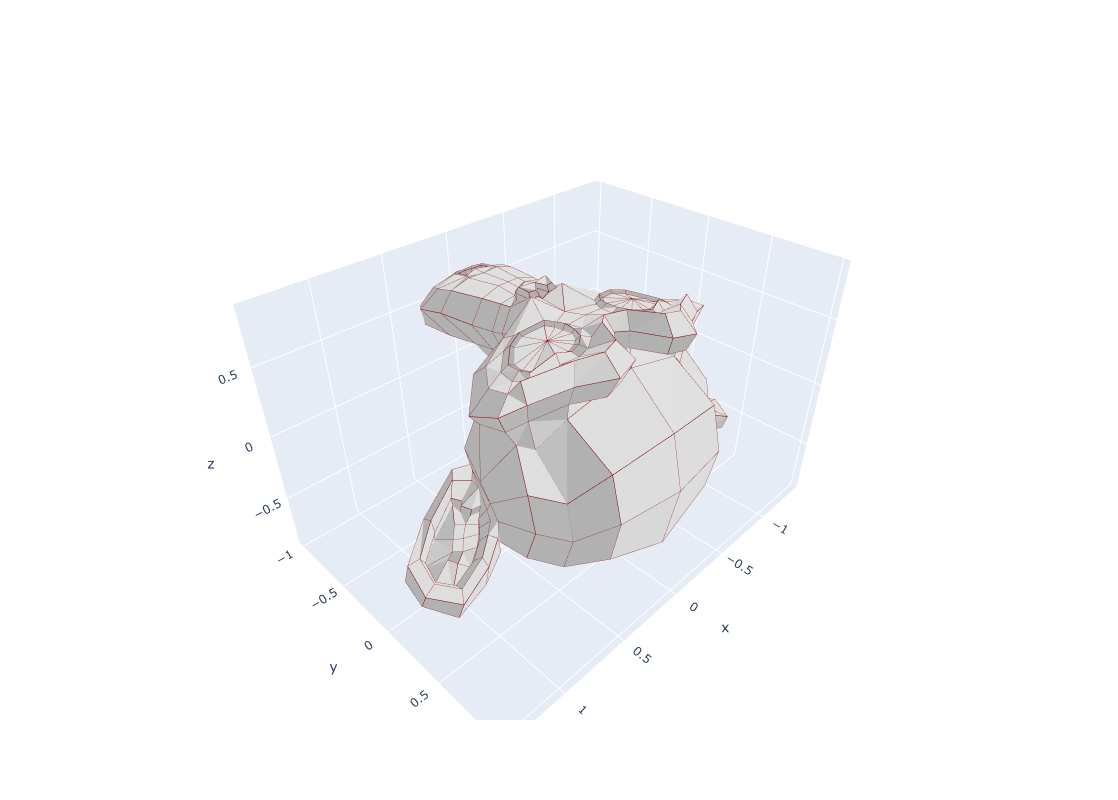

In [11]:
jd.display(suzanne, smooth=False)

We arbitrarily choose to pin the extremal vertices along the y axis to uv coordinates $(0,0)$ and $(1,1)$

In [12]:
hmesh.triangulate(suzanne)

fsize = len(suzanne.faces())
vsize = len(suzanne.vertices())

lowy = np.argmin(suzanne.positions()[:,1])
highy = np.argmax(suzanne.positions()[:,1])

Pinning vertices translates into removing these from the variables, hence the need for reindexing the variables.

In [13]:
def variable_index(i):
    if i == lowy:
        return -1
    if i == highy:
        return -2
    res = i
    if i > lowy:
        res -= 1
    if i > highy:
        res -= 1
    return res

We now build the system according to the desired equations.

In [14]:
system = np.zeros((2*fsize, 2*(vsize - 2)))
rhs = np.zeros((2*fsize, 4))

for f in suzanne.faces():
    v = list(suzanne.circulate_face(f))
    p = [suzanne.positions()[vv] for vv in v]
        
    #local basis
    e0 = p[1] - p[0]
    e0 /= np.linalg.norm(e0)
    e2 = np.cross(e0, p[2] - p[0])
    e1 = np.cross(e2, e0)
    e1 /= np.linalg.norm(e1)
        
    #twice the triangle area
    dt = math.sqrt(np.linalg.norm(np.cross(p[1] - p[0], p[2] - p[0])))
        
    #local coordinates
    px = [(pp - p[0]).dot(e0) for pp in p]
    py = [(pp - p[0]).dot(e1) for pp in p]
        
    #fill matrices
    for i in range(3):
        dax = py[(i+1)%3] - py[(i+2)%3]
        day = px[(i+2)%3] - px[(i+1)%3]
        dax /= dt
        day /= dt
        var = variable_index(v[i])
        # da0x v0 + da1x v1 + da2x v2 = - da0y u0 - da1y u1 - da2y u2
        # da0y v0 + da1y v1 + da2y v2 = da0x u0 + da1x u1 + da2x u2
        if var < 0:
            rhs[2*f,2*(-var-1)] = -day
            rhs[2*f,2*(-var-1)+1] = -dax
            rhs[2*f+1,2*(-var-1)] = dax
            rhs[2*f+1,2*(-var-1)+1] = -day
        else:
            system[2*f,2*var] = day
            system[2*f, 2*var+1] = dax
            system[2*f+1, 2*var] = -dax
            system[2*f+1, 2*var+1] = day

This system is then solved in the least squares fashion, multiplying both sides of the system by $M^T$

In [15]:
pins = np.matrix([[0, 0],[1, 1]])
lsq_system = np.asmatrix(system).T * np.asmatrix(system)
lsq_rhs = np.asmatrix(system).T * np.asmatrix(rhs) * pins.reshape((4, 1))

In [16]:
solution = np.linalg.solve(lsq_system,lsq_rhs).reshape((vsize-2, 2))

We can now transfer the solution from the reindexed variables into actual uv coordinates

In [17]:
uv = np.zeros((vsize, 2))

for v in suzanne.vertices():
    var = variable_index(v)
    if var < 0:
        uv[v] = pins[-var-1]
    else:
        uv[v] = solution[var]

And here comes the resulting unfolding of the mesh.

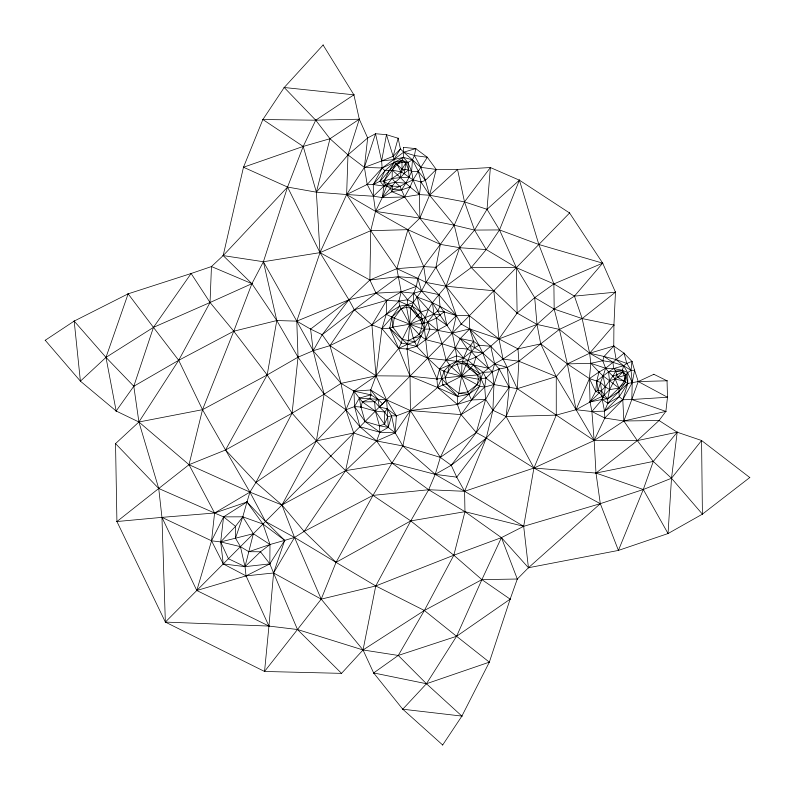

In [18]:
fig,ax = plt.subplots(figsize=(10,10))
plt.triplot(uv[:,0], uv[:,1], [suzanne.circulate_face(f) for f in suzanne.faces()], linewidth=0.5, color='black')
plt.axis('off')
plt.show()